In [ ]:
import sys
sys.path.append("../")
import pandas as pd
# warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import numpy as np
import config as cf
import matplotlib.pyplot as plt
import talib
from datetime import datetime
from numpy import NaN
from random import randint

### Load symbol for trading

In [ ]:
%store -r tickers

In [ ]:
tickers

In [ ]:
TRADE_TIMEFRAME = "4h"
GRANULAR_TIMEFRAME = "5m"
MACD_FAST = 26
MACD_SLOW= 12
MACD_SIGNAL= 9
SHORT_MULTIPLES = 1
MEDIUM_MULTIPLES = 3
LONG_MULTIPLES = 8
TRADE_TIMEFRAME_IN_MS = 4 * 60 * 60 * 1000
MARKET_CYCLE_SPEED = ["FAST","MEDIUM","SLOW"]
STOP_LOSS = 0.3
TAKE_PROFIT = 0.3

#### Loading trading data

In [ ]:
dfs = dict()
print("...loading...")
for ticker in tickers:
    symbol = ticker["symbol"]
    if str(symbol).endswith("USDT"):
        print(symbol, end=" ")
        filename = f"{cf.AGGREGATED_DATA_PATH}futures/{TRADE_TIMEFRAME}/{symbol}-{TRADE_TIMEFRAME}.h5"
        df = pd.read_hdf(filename)
        dfs[symbol] = df

##### Loading granular data to check take profit and stop loss

In [ ]:
gdfs = dict()
print("...loading...")
for ticker in tickers:
    symbol = ticker["symbol"]
    if str(symbol).endswith("USDT"):
        print(symbol, end=" ")
        filename = f"{cf.AGGREGATED_DATA_PATH}futures/{GRANULAR_TIMEFRAME}/{symbol}-{GRANULAR_TIMEFRAME}.h5"
        gdf = pd.read_hdf(filename)
        gdfs[symbol] = gdf

##### Get key info of the trading data such as length, last index, completeness

In [ ]:
len_list = []
coverage_list = []
last_list = []
TRADE_TIMEFRAME_IN_MS = 4 * 60 * 60 * 1000
for symbol in dfs.keys():
    len_list.append(len(dfs[symbol]))
    must_length = (dfs[symbol].index.max()-dfs[symbol].index.min())/TRADE_TIMEFRAME_IN_MS+1
    real_length = len(dfs[symbol])
    coverage_list.append(real_length/must_length)
    last_list.append(dfs[symbol].index.max())
stat_df = pd.DataFrame({"symbol": dfs.keys(), "length": len_list,\
    "coverage":coverage_list, "last":last_list})

In [ ]:
stat_df

##### Select symbols for trading

In [ ]:
selected_symbols = stat_df[(stat_df["coverage"]==1)&\
    (stat_df["length"]>600*6)]["symbol"].values.tolist()    #type: ignore
selected_symbols_include_btc = selected_symbols + ["BTCUSDT"]

##### Prepare data

In [ ]:
def preprocessing(trade_duration,holding_period,stat_df,dfs):
    
    selected_symbols = stat_df[(stat_df["length"]>trade_duration+holding_period)&\
        (stat_df["coverage"]==1)]["symbol"].values.tolist()
    selected_symbols_include_btc = selected_symbols + ["BTCUSDT"]
    print("...preprocessing, calculate MACD ...")
    for symbol in selected_symbols_include_btc:
        df = dfs[symbol]
        df[f"{symbol}_LOG_RETURN"] = np.log(df["Close"].pct_change()+1)
        
        _,_,df[f"{symbol}_FAST_MACD"] = talib.MACD(df["Close"],fastperiod=MACD_FAST,\   
        slowperiod=MACD_SLOW,signalperiod=MACD_SIGNAL)
        df[f"{symbol}_FAST_MACD"] = df[f"{symbol}_FAST_MACD"]/df["Close"]
        
        _,_,df[f"{symbol}_MEDIUM_MACD"] = talib.MACD(df["Close"],fastperiod=MACD_FAST*MEDIUM_MULTIPLES,\
            slowperiod=MACD_SLOW*MEDIUM_MULTIPLES,signalperiod=MACD_SIGNAL*MEDIUM_MULTIPLES)
        df[f"{symbol}_MEDIUM_MACD"] = df[f"{symbol}_MEDIUM_MACD"]/df["Close"]
        
        _,_,df[f"{symbol}_SLOW_MACD"] = talib.MACD(df["Close"],fastperiod=MACD_FAST*LONG_MULTIPLES,\
            slowperiod=MACD_SLOW*LONG_MULTIPLES,signalperiod=MACD_SIGNAL*LONG_MULTIPLES)
        df[f"{symbol}_SLOW_MACD"] = df[f"{symbol}_SLOW_MACD"]/df["Close"]
    
    # We need BTC price to draw graph 
    BITCOIN_PRICE = dfs["BTCUSDT"]["Close"]
    BITCOIN_PRICE.name = "BITCOIN_PRICE"

    merged_df = pd.concat([dfs[symbol][[f"{symbol}_LOG_RETURN",\
        f"{symbol}_FAST_MACD",f"{symbol}_MEDIUM_MACD",f"{symbol}_SLOW_MACD"]]\
            for symbol in selected_symbols_include_btc] + [BITCOIN_PRICE],axis=1)
    
    merged_df.sort_index(ascending=True,inplace=True)
    merged_df.fillna(method="ffill", inplace = True)
    merged_df.dropna(inplace=True)

    return merged_df, selected_symbols

In [ ]:
def calculate_macd_diff_with_btc(merged_df:pd.DataFrame,selected_symbols:list[str]):
    
    print("...calculating MACD diff between altcoins and BTC...")
    df = merged_df.copy()
    
    #Calculating diff
    for symbol in selected_symbols:
        for cycle in MARKET_CYCLE_SPEED:
            diff = df[f"{symbol}_{cycle}_MACD"] - df[f"BTCUSDT_{cycle}_MACD"]
            diff.name = f"{symbol}_DIFF_{cycle}"
            
            diff_bear = df[df["BTCUSDT_SLOW_MACD"]<0][f"{symbol}_{cycle}_MACD"] \
                - df[df["BTCUSDT_SLOW_MACD"]<0][f"BTCUSDT_{cycle}_MACD"]
            diff_bear.name = f"{symbol}_DIFF_{cycle}_BEAR"
            
            diff_bull = df[df["BTCUSDT_SLOW_MACD"]>0][f"{symbol}_{cycle}_MACD"] \
            - df[df["BTCUSDT_SLOW_MACD"]>0][f"BTCUSDT_{cycle}_MACD"]
            diff_bull.name = f"{symbol}_DIFF_{cycle}_BULL"
            
            df = pd.concat([df,diff,diff_bear,diff_bull],axis=1)     
               
    return df  

In [ ]:
def calculate_macd_diff_mean(merged_df):
    #Calculating rolling diff mean
    df = merged_df.copy()
    print("...calculating MACD diff mean...")
    for symbol in selected_symbols:
        for cycle in MARKET_CYCLE_SPEED:
            diff_bear_mean = df[f"{symbol}_DIFF_{cycle}_BEAR"].expanding().mean() 
            diff_bear_mean.name = f"{symbol}_DIFF_{cycle}_BEAR_MEAN"
            diff_bull_mean = df[f"{symbol}_DIFF_{cycle}_BULL"].expanding().mean() 
            diff_bull_mean.name = f"{symbol}_DIFF_{cycle}_BULL_MEAN"
            df = pd.concat([df,diff_bear_mean,diff_bull_mean],axis=1)

    return df

In [163]:
def make_market_trend(merged_df,key):
    #Make market trend data
    shifted = merged_df[merged_df[key] * merged_df[key].shift()<0].copy()
    shifted = pd.concat([shifted,merged_df.head(1)],axis=0)
    shifted.sort_index(inplace=True,ascending=True)
    shifted["start"] = shifted.index
    shifted["end"] = shifted["start"].shift(-1)
    shifted["value"] = shifted[key]
    return shifted[["end","value"]]


def plot_results(trade_df:pd.DataFrame, market_trend:pd.DataFrame):
    fig,ax = plt.subplots()
    
    fig.set_dpi(720)
    fig.set_size_inches(10,6)
    
    for i in market_trend.index:
        row = market_trend.loc[i,:]
        start = i
        end = row["end"]
        color = "tab:green" if row["value"] > 0 else "tab:red" 
        ax.axvspan(start, end, color=color, alpha=0.1,linewidth=1)  #type: ignore
    
    #Draw 
    ax.plot(trade_df["open"],trade_df["cumsum_profit"],c="b",linewidth=1,label="cumsum_profit")
    ax.plot(trade_df["open"],trade_df["cumsum_long_profit"],c="g",linewidth=1,label="cumsum_long_profit")
    ax.plot(trade_df["open"],trade_df["cumsum_short_profit"],c="r",linewidth=1,label="cumsum_short_profit")
    ax.plot(trade_df["open"],trade_df["cumsum_trading_cost"],c="y",linewidth=1,label="cumsum_trading_cost")
    
    highest = max(trade_df["cumsum_long_profit"].max(),trade_df["cumsum_long_profit"].max(),trade_df["cumsum_profit"].max())
    btc_highest = trade_df["BITCOIN_PRICE"].max()
    
    ax.plot(trade_df["open"],trade_df["BITCOIN_PRICE"]*highest/btc_highest,color="tab:gray",linewidth=1,label="BITCOIN")
    ax.plot(trade_df["open"],[0 for i in range(len(trade_df))],color="black",linewidth=1)
    
    plt.legend()
    plt.show()

In [ ]:
def get_aggregate_report(trade_df,holding_period):
    profit = trade_df.groupby("open")["profit"].sum()
    profit.name = "profit"
    aggreegate_df = pd.DataFrame(index = [i for i in range(int(trade_df["open"].min()),int(trade_df["open"].max()),TRADE_TIMEFRAME_IN_MS)],data = {"profit":profit})
    aggreegate_df["real_profit"] =aggreegate_df["profit"].shift(holding_period)
    aggreegate_df["equity"] = 100_000
    aggreegate_df.fillna(0,inplace=True)
    aggreegate_df["cumsum_profit"] = aggreegate_df["real_profit"].cumsum()
    aggreegate_df["balance"] = aggreegate_df["equity"] + aggreegate_df["cumsum_profit"]
    aggreegate_df["return"] = aggreegate_df["balance"].pct_change()
    return aggreegate_df

def get_sharpe(aggreegate_df,risk_free_rate:float = 0.05):
    return (aggreegate_df["return"].mean()- risk_free_rate/(365*6))/aggreegate_df["return"].std() * np.sqrt(365*6)

#### Strategy 1: Arbitrage altcoin agains Bitcoin. 
##### If market is bull, long up to 5  altcoins that rise fastest and faster than BITCOIN, short BITCOIN. If market is bear, short up to 5 altcoins that drop fastest and faster than BITCOIN, long BITCOIN.

In [ ]:
def arbitrage_bitcoin_altcoin(row, market_cycle,altcoin_cycle,n_pairs):
     # Selecting long and short candidate   
 
    is_bull = False
    long_symbols = []
    short_symbols = []
    long_dict = dict()  
    short_dict = dict()
    if row[f"BTCUSDT_{market_cycle}_MACD"] > 0:
        is_bull = True
    
    diff_dict = dict()  
    if (is_bull):
        for symbol in selected_symbols:
            diff = row[f"{symbol}_DIFF_{altcoin_cycle}_BULL"]
            diff_mean = row[f"{symbol}_DIFF_{altcoin_cycle}_BULL_MEAN"]
        
            if (diff > 0) & (diff_mean > 0):
                diff_dict[diff] = symbol
                long_dict[symbol] = diff
        
        sorted_symbol = sorted(diff_dict,reverse=True)
        long_symbols = [diff_dict[sorted_symbol[i]] for i in range(min(len(sorted_symbol),n_pairs))]
        
        if long_symbols:
            short_symbols = ["BTCUSDT"]  
            short_dict["BTCUSDT"] = 0    
    else: 
        for symbol in selected_symbols:
            diff = row[f"{symbol}_DIFF_{altcoin_cycle}_BULL"]
            diff_mean = row[f"{symbol}_DIFF_{altcoin_cycle}_BULL_MEAN"]
        
            if (diff < 0) & (diff_mean < 0):
                diff_dict[diff] = symbol
                short_dict[symbol] = diff
                
        sorted_symbol = sorted(diff_dict,reverse=False)
        short_symbols = [diff_dict[sorted_symbol[i]] for i in range(min(len(sorted_symbol),n_pairs))]
        
        if short_symbols:
            long_symbols = ["BTCUSDT"]
            long_dict["BTCUSDT"] = 0  
    
    return long_symbols, short_symbols, long_dict, short_dict
    

#### Strategy 2: Arbitrage altcoin both sides
##### If market is bull, long up to 5  altcoins that rise fastest and faster than Bitcoin, short 5 altcoins that rise slowest and slower than Bitcoin. If market is bear, long up to 5 coin that raise fastest and faster than Bitcoin, short upto 5 that raise slowest and slower to Bitcoin.

In [ ]:
def arbitrate_both_sides(row,market_cycle,altcoin_cycle,n_pairs):
    
    is_bull = False
    long_symbols = short_symbols = []
    
    if row[f"BTCUSDT_{market_cycle}_MACD"] > 0:
        is_bull = True
    
    long_dict = dict()  
    short_dict = dict()
    inv_long_dict = dict()
    inv_short_dict = dict()
    
    for symbol in selected_symbols:
        if (is_bull):
            diff = float(row[f"{symbol}_DIFF_{altcoin_cycle}_BULL"])
            diff_mean = float(row[f"{symbol}_DIFF_{altcoin_cycle}_BULL_MEAN"])
        else:
            diff = float(row[f"{symbol}_DIFF_{altcoin_cycle}_BEAR"])
            diff_mean = float(row[f"{symbol}_DIFF_{altcoin_cycle}_BEAR_MEAN"])
        
        if (diff_mean > 0) & (diff > 0):
            long_dict[symbol] = diff_mean
            inv_long_dict[diff_mean] = symbol
        elif (diff_mean < 0) & (diff < 0):
            short_dict[symbol] = diff_mean
            inv_short_dict[diff_mean] = symbol
            
    sorted_inv_long_dict = sorted(inv_long_dict,reverse=True)
    long_symbols = [inv_long_dict[sorted_inv_long_dict[i]] for i in range(min(len(long_dict),n_pairs))]
        
    sorted_inv_short_dict = sorted(inv_short_dict,reverse=False)
    short_symbols = [inv_short_dict[sorted_inv_short_dict[i]] for i in range(min(len(short_dict),n_pairs))]
    
    long_dict["BTCUSDT"] = 0
    short_dict["BTCUSDT"] = 0
    
    if long_symbols and not short_symbols:
        short_symbols += ["BTCUSDT"]
    elif short_symbols and not long_symbols:
        long_symbols += ["BTCUSDT"]
    
    return long_symbols, short_symbols, long_dict, short_dict

In [ ]:
def get_holding_period(trade_start,trade_end,time,period_start, period_end):
    pace = (period_end - period_start)/(trade_end-trade_start)
    period = period_start + (time - trade_start) * pace 
    return int(period)

In [ ]:
def check_if_hit_stoploss_or_take_profit(symbol:str,enter_time:int,end_time:int,take_profit:float,stop_loss:float,type:str):
    
    df = gdfs[symbol].loc[enter_time:end_time]
    
    try:
        enter_price = dfs[symbol].loc[enter_time,:]["Close"]
        if (enter_price is NaN):
            assert ValueError("enter price is not a number")
    except Exception as e:
        print(e)
        assert ValueError(f"Error at {symbol} {enter_time}")
         
    out = 0
    
    if type == "LONG":
        take_profit_price = enter_price * (1+take_profit)           #type: ignore
        stop_loss_price = enter_price * (1-stop_loss)               #type: ignore
   
        first_index_high = df.loc[df["High"]>=take_profit_price].index.min()
        first_index_low = df.loc[df["Low"]<=stop_loss_price].index.min()
        
    elif type == "SHORT":
        take_profit_price = enter_price * (1-take_profit)           #type: ignore
        stop_loss_price = enter_price * (1+stop_loss)               #type: ignore
        
        first_index_low = df.loc[df["Low"]<=take_profit_price].index.min()
        first_index_high = df.loc[df["High"]>=stop_loss_price].index.min()
     
    else:
        assert ValueError("type must be LONG or Short")
    
    if first_index_high is NaN:                 #type: ignore
        if first_index_low is NaN: # both stop loss and take profit not reached #ignore: type   #type: ignore
            out = 0 
        else: #first_index_low is not NaN, mean only take profit reached
            out = 1
            # print(f"{type} {symbol}  at {enter_price} {first_index_high} {first_index_low}, stoploss at {stop_loss_price},takeprofit {take_profit_price}, only take_profit reached at {first_index_low}")
    else:
        if first_index_low is NaN: # Only first_index_high is not NaN   #type: ignore
            out = -1
            # print(f"{type} {symbol} at {enter_price} {first_index_high} {first_index_low}, stoploss at {stop_loss_price}, takeprofit {take_profit_price}, only stop_loss reached at {first_index_high}")
        else: # Both first_index_low and first_index_high is not NaN
            if first_index_low < first_index_high: # take profit reached first  #type: ignore
                out = 1
                # print(f"{type} {symbol} at {enter_price} {first_index_high} {first_index_low}, stoploss {stop_loss_price}, takeprofit {take_profit_price}, take_profit reached first at {first_index_low}")
            elif first_index_low == first_index_high: # both reached in the same timeframe  #type: ignore
                if (randint(0,99) < 50):
                    out = -1
                    # print(f"{type} {symbol} at {enter_price} {first_index_high} {first_index_low}, stoploss {stop_loss_price}, takeprofit {take_profit_price}, randomly take_profit at {first_index_low}")
                else:
                    out = 1 
                    # print(f"{type} {symbol} at {enter_price} {first_index_high} {first_index_low}, stoploss {stop_loss_price}, takeprofit {take_profit_price}, randomly stop_loss {symbol} at {first_index_low}")    
            else: # first_index_low > first_index_high, mean stop loss reached first
                out = -1
                # print(f"{type} {symbol} at {enter_price} {first_index_high} {first_index_low}, stoploss {stop_loss_price}, takeprofit {take_profit_price}, Stop_loss reached first at {first_index_high}")
  
    return out if type == "SHORT" else -out
    

In [ ]:
def get_investment_amount_by_ranking(budget:float,position:int,total_number:int,discount:float=0.1):
    weight = [(1-discount)**i for i in range(total_number)]
    total_weight = np.array(weight).sum()
    return budget * weight[position]/total_weight if total_weight > 0 else 0

def get_investment_amount_by_diff_value(budget:float,symbol:str,diff_dict:dict):
    diff = abs(diff_dict[symbol])
    diff_total = np.abs(np.array(list(diff_dict.values()))).sum()
    return np.log(1+diff/diff_total) * budget if diff_total > 0 else 0

def get_investment_amount_by_equal_split(budget:float,number:int):
    return budget/number if number > 0 else 0

In [ ]:
def run_strategy(
    trade_duration:int,
    leverage:float,
    n_pairs:int,
    period_start:int,
    period_end:int,
    verbose:int,
    balance:int,
    trading_fee:float,
    take_profit_long: float,
    stop_loss_long:float,
    take_profit_short: float,
    stop_loss_short:float,
    altcoin_cycle:str,
    market_cycle:str,
    strategy = 1,
    plot:bool = True,
    ):


    merged_df, selected_symbols = preprocessing(
        dfs=dfs,
        stat_df=stat_df,
        trade_duration=trade_duration,
        holding_period=period_end
    )

    merged_df = calculate_macd_diff_with_btc(
        merged_df=merged_df,
        selected_symbols=selected_symbols
    )

    merged_df = calculate_macd_diff_mean(merged_df)

    trade_end = int(merged_df.index.max() - period_end * TRADE_TIMEFRAME_IN_MS)
    trade_start = int(min(max(trade_end - trade_duration * TRADE_TIMEFRAME_IN_MS, merged_df.index.min()),trade_end))

    #Check if any missing open-time index
    for i in range (trade_start,trade_end,TRADE_TIMEFRAME_IN_MS):
        if not i in merged_df.index:
            print(f"miss {i}")

    btc_init_price = merged_df.loc[trade_start,:]["BITCOIN_PRICE"]

    trade_df = pd.DataFrame({"open":[trade_start],"datetime":[""], "symbol":[""],"type":[""], "amount":[0], "profit":[0],\
        "cost":[0],"balance":[balance], "close_type":[""], "BITCOIN_PRICE":[btc_init_price]})

    balance = balance
    profit_before_cost = 0

    print("...backtesting...")
    open_unix_time = trade_start

    while open_unix_time < trade_end:
        
        date_time = datetime.utcfromtimestamp(open_unix_time/1000).strftime('%Y-%m-%d %H:%M:%S')
        row = merged_df.loc[open_unix_time,:].copy()
        
        holding_period = get_holding_period(
            trade_start=trade_start,trade_end=trade_end,
            time=open_unix_time,period_start=period_start,period_end=period_end)
        
        #Executing trade
        trade_symbols = []
        trade_types = []
        trade_costs = []
        trade_profits = []
        invest_amounts = []
        
        balances = []
        BITCOIN_PRICEs = []
        close_types = []

        if strategy == 1:
            long_symbols, short_symbols, long_dict, short_dict \
                = arbitrage_bitcoin_altcoin(
                    row=row,
                    market_cycle=market_cycle,
                    altcoin_cycle=altcoin_cycle,
                    n_pairs=n_pairs)
        else: 
            long_symbols, short_symbols, long_dict, short_dict =\
                arbitrate_both_sides(
                row=row,
                market_cycle=market_cycle,
                altcoin_cycle=altcoin_cycle,
                n_pairs=n_pairs)

 
        short_budget = long_budget = leverage * balance/2
        trade_num = len(long_symbols) + len(short_symbols)
        enter_time = open_unix_time + TRADE_TIMEFRAME_IN_MS
        end_time = open_unix_time + (1+holding_period) * TRADE_TIMEFRAME_IN_MS
        
        for i in range(len(long_symbols)):
            symbol = long_symbols[i]
            
            status = check_if_hit_stoploss_or_take_profit(
                symbol = symbol,
                enter_time = enter_time,
                end_time = end_time,
                type = "LONG",
                take_profit=take_profit_long,
                stop_loss=stop_loss_long,
            )
            
            invest_amount = get_investment_amount_by_equal_split(
                budget=long_budget,
                number=len(long_symbols)
            )
            
            match status:
                case 0:
                    cumsum_log_return = merged_df.loc[enter_time:end_time,:][f"{symbol}_LOG_RETURN"].sum()
                case -1:
                    cumsum_log_return = np.log(1-STOP_LOSS)
                case 1:
                    cumsum_log_return = np.log(1+TAKE_PROFIT)   
                
            profit_before_cost = invest_amount * (np.exp(cumsum_log_return)-1)
            cost = invest_amount * 2 * trading_fee
            profit = profit_before_cost - cost
            balance += profit #type: ignore
            trade_symbols.append(symbol)
            trade_types.append("long")
            trade_costs.append(cost)
            trade_profits.append(profit)
            invest_amounts.append(invest_amount)
            balances.append(balance)
            close_types.append(status)
            BITCOIN_PRICEs.append(row["BITCOIN_PRICE"])
        
        for i in range(len(short_symbols)):
            symbol = short_symbols[i]
            
            invest_amount = get_investment_amount_by_equal_split(
                budget=short_budget,
                number=len(short_symbols)
            )
            
            status = check_if_hit_stoploss_or_take_profit(
                symbol = symbol,
                enter_time = enter_time,
                end_time = end_time,
                type = "SHORT",
                take_profit=take_profit_short,
                stop_loss=stop_loss_short,
            )
            
            match status:
                case 0:
                    cumsum_log_return = -merged_df.loc[enter_time:end_time,:][f"{symbol}_LOG_RETURN"].sum()
                case -1:
                    cumsum_log_return = np.log(1-STOP_LOSS)
                case 1:
                    cumsum_log_return = np.log(1+TAKE_PROFIT)  
            
            profit_before_cost = invest_amount * (np.exp(cumsum_log_return)-1)
            cost = invest_amount * 2 * trading_fee
            profit = profit_before_cost - cost
            balance += profit #type: ignore
            trade_symbols.append(symbol)
            trade_types.append("short")
            trade_profits.append(profit)
            invest_amounts.append(invest_amount)
            trade_costs.append(cost)
            balances.append(balance)
            close_types.append(status)
            BITCOIN_PRICEs.append(row["BITCOIN_PRICE"])

        times = [open_unix_time for i in range(trade_num)]
        date_times = [date_time for i in range(trade_num)]

        new_rows =pd.DataFrame({"open": times, "datetime": date_times, "symbol":trade_symbols,\
            "type":trade_types,"amount":invest_amounts, "profit":trade_profits, \
                "cost":trade_costs,"balance":balances, "close_type":close_types, "BITCOIN_PRICE":BITCOIN_PRICEs})
        
        trade_df = pd.concat([trade_df,new_rows],ignore_index=True)
        
        if verbose == 1:
            print(date_time)
            print(f"LONG {[(symbol,long_dict[symbol]) for symbol in long_symbols]}")
            print(f"SHORT {[(symbol,short_dict[symbol]) for symbol in short_symbols]}")
        elif verbose == 0:
            pass
        else:
            raise ValueError("verbose: 0 or 1")
        
        open_unix_time += holding_period * TRADE_TIMEFRAME_IN_MS 

    trade_df["cumsum_profit"] = trade_df["profit"].cumsum()
    trade_df["cumsum_long_profit"] = trade_df[trade_df["type"] == "long"]["profit"].cumsum()
    trade_df["cumsum_short_profit"] = trade_df[trade_df["type"] == "short"]["profit"].cumsum()
    trade_df["cumsum_trading_cost"] = trade_df["cost"].cumsum()
    trade_df.fillna(method="ffill", inplace = True)

    if plot == True:
        market_df = make_market_trend(merged_df,f"BTCUSDT_{market_cycle}_MACD")
        plot_results(trade_df,market_df)
    
    # aggreegate_df = get_aggregate_report(trade_df=trade_df,holding_period=holding_period)

    # sharpe_ratio = get_sharpe(aggreegate_df)

    # return sharpe_ratio

    return trade_df, merged_df

...preprocessing, calculate MACD ...
...calculating MACD diff between altcoins and BTC...
...calculating MACD diff mean...
...backtesting...


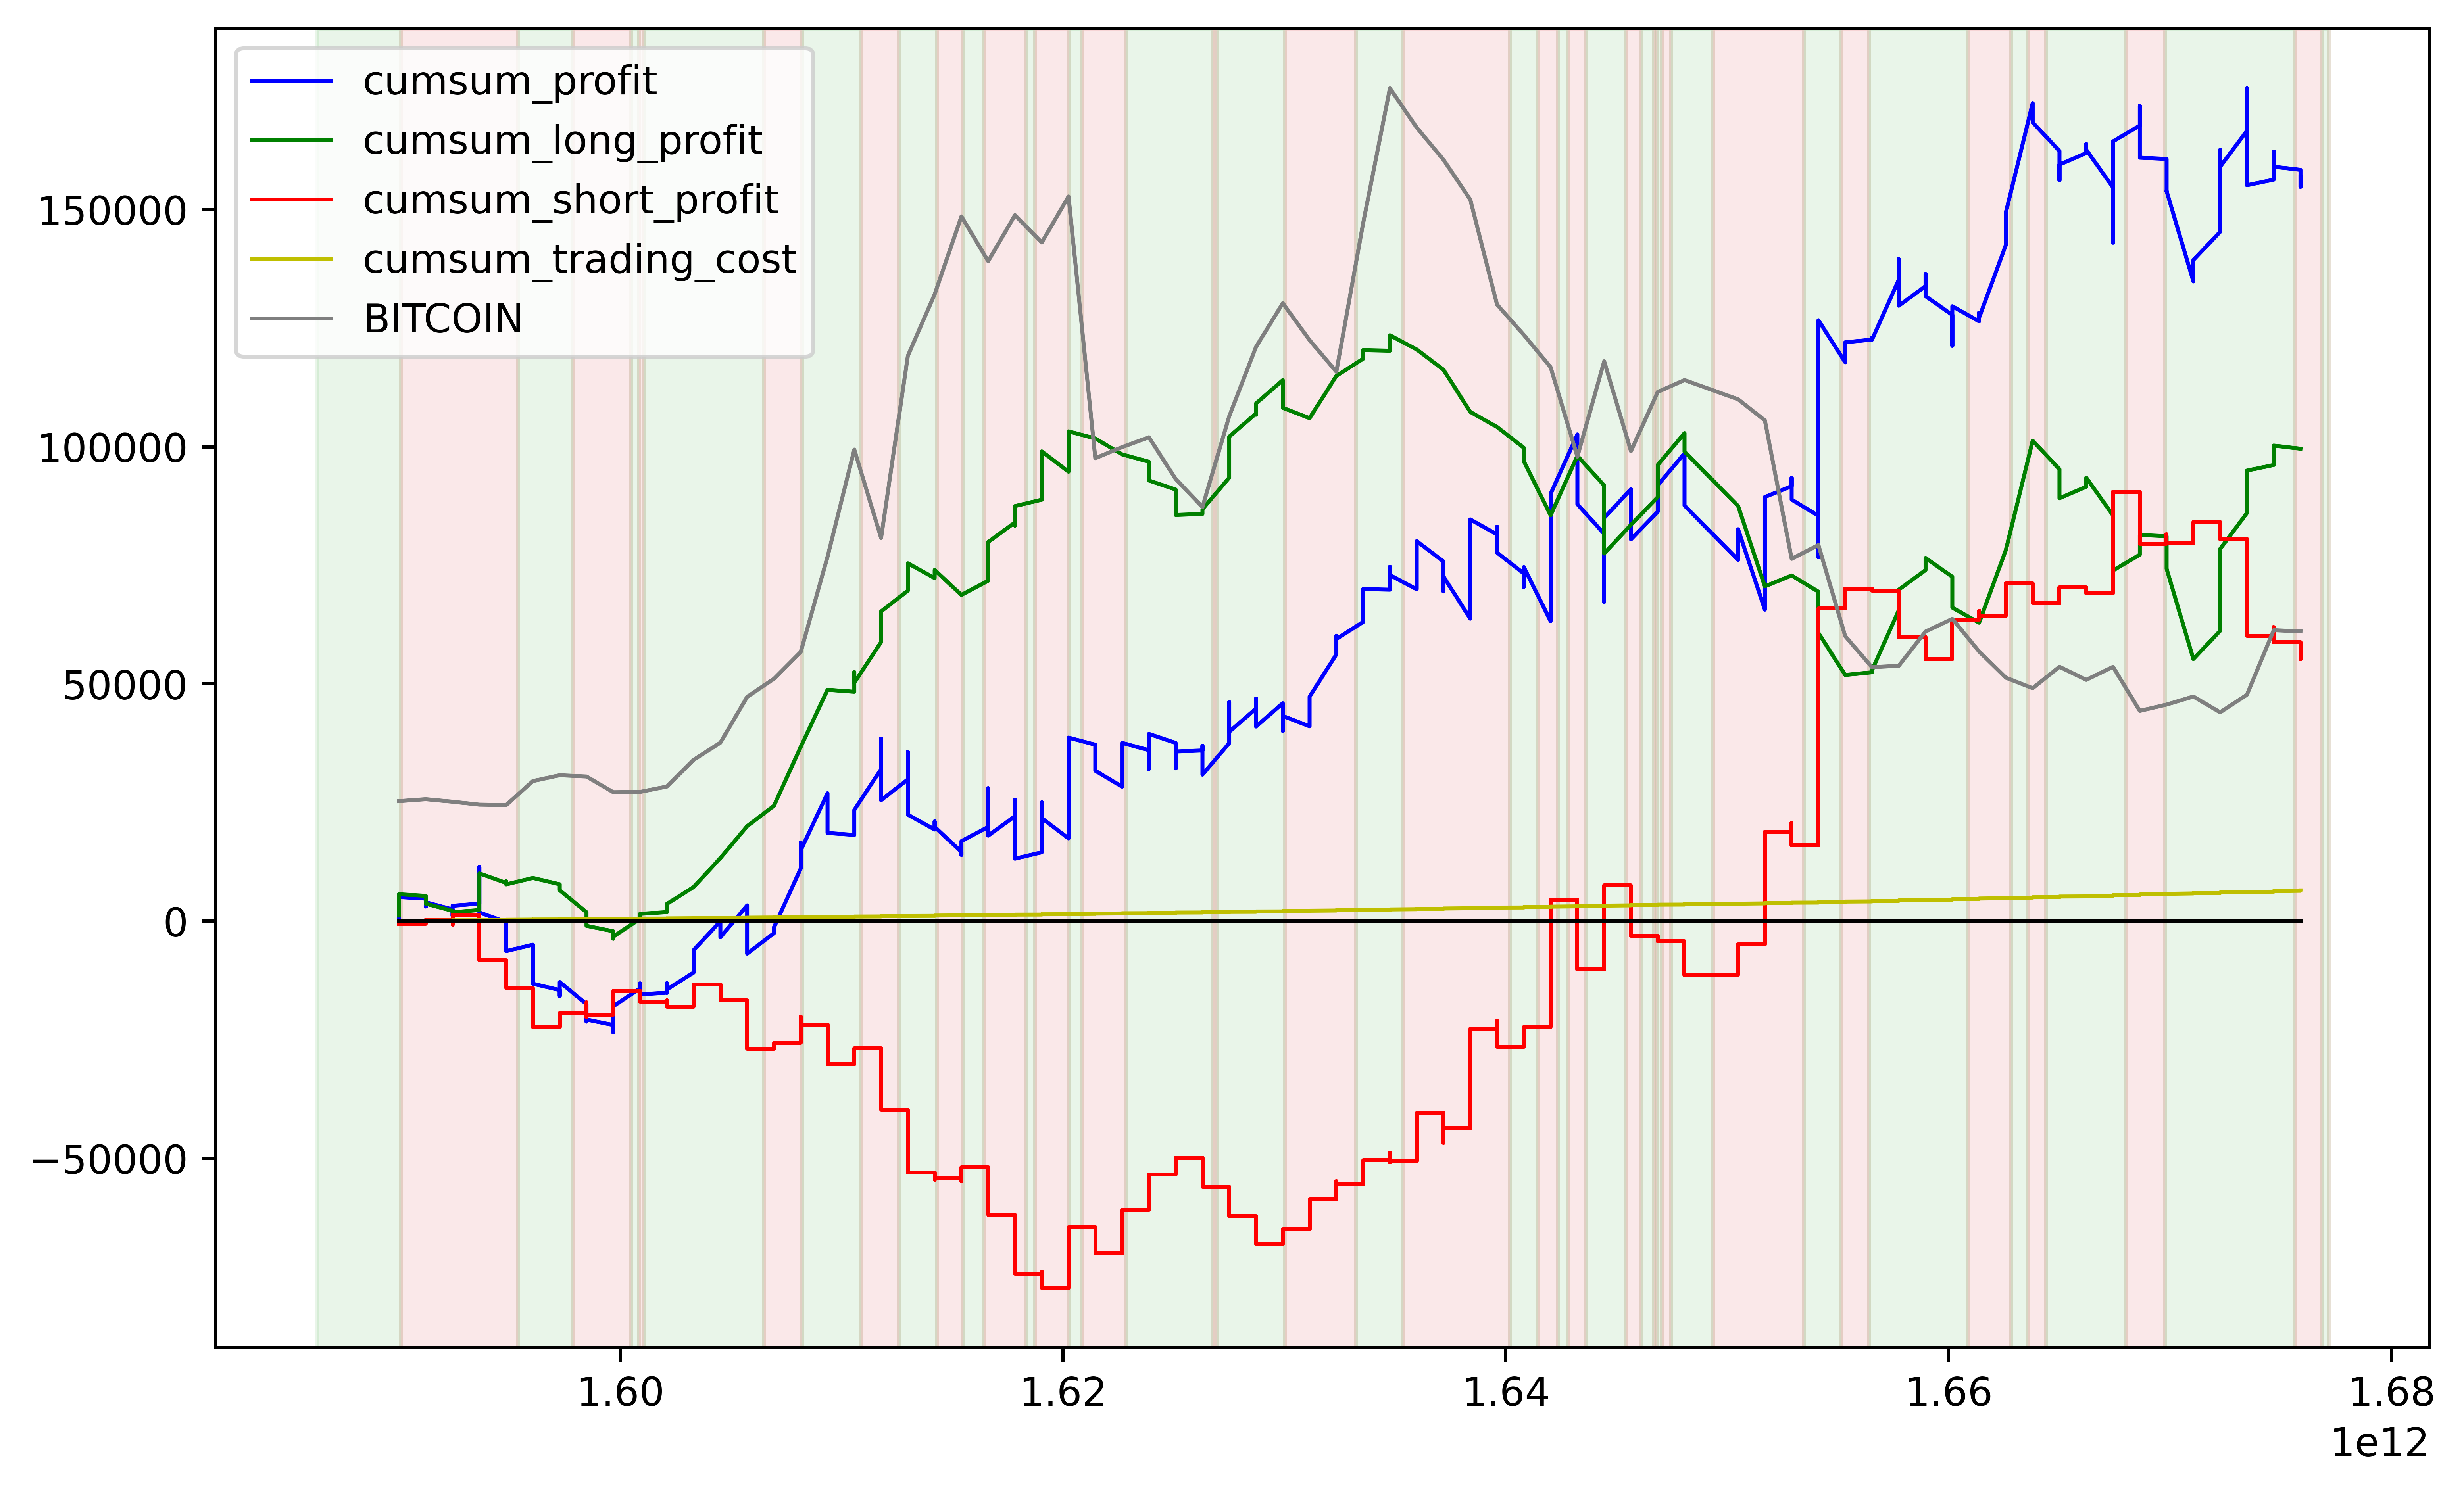

In [167]:
trade_df = run_strategy(
    leverage = 0.7,
    trade_duration = 1000 * 6,
    n_pairs = 3,
    period_start = 14 * 6,
    period_end = 14 * 6,
    verbose = 0,
    balance = 100_000,
    trading_fee = 0.0004,
    take_profit_long = 0.5,
    stop_loss_long = 0.5,
    take_profit_short = 0.5,
    stop_loss_short = 0.5,
    altcoin_cycle = "MEDIUM",
    market_cycle = "SLOW",
    strategy = 2,
    plot=True
)


In [ ]:
print(trade_df["type"].value_counts())
print(trade_df["close_type"].value_counts())
print(trade_df[trade_df["type"]=="long"]["close_type"].value_counts())
print(trade_df[trade_df["type"]=="short"]["close_type"].value_counts())